In [1]:
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.estimator_class import loglikelihood_estimator_bfgs
from functions.multivariate_exponential_process import *
import scipy
from functions.estimator_class_multi_rep import *


R[write to console]: De plus : 
R[write to console]: Messages d'avis :

R[write to console]: 1: 
R[write to console]: Dans (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  la bibliothèque ‘/usr/lib/R/site-library’ ne contient aucun package

R[write to console]: 2: 
R[write to console]: Dans (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  la bibliothèque ‘/usr/lib/R/site-library’ ne contient aucun package

R[write to console]: 3: 
R[write to console]: Dans (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  la bibliothèque ‘/usr/lib/R/site-library’ ne contient aucun package



In [2]:
np.random.seed(0)

### Simulation of a Marked Exponential Hawkes Process

We start by simulating a unidimensionnal Hawkes process denoted $N$. The intensity of the process is given by the formula : 
\begin{equation}
   \lambda(t) =   m + \int_{(-\infty ,t)\times \mathcal{E} } a e^{-b(t-s)} \phi_{\gamma, \psi}(\kappa) N(ds \times d\kappa),
\end{equation}

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [3]:
m, a, b = 0.8, -1, 2
Tmax = 5

## taking kappa i.i.d following a exponential distribution of parameter 1
def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

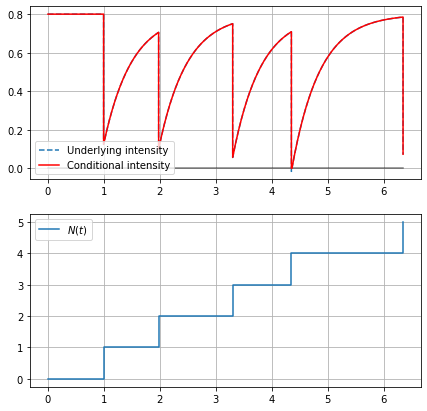

In [4]:
hawkes = exp_thinning_hawkes_marked(m=m,
                                    a=a, 
                                    b=b, 
                                    F = F ,
                                    arg_F = {'psi':2},
                                    phi=phi, 
                                    arg_phi = {'gamma': 1},
                                    max_jumps = 5 )


hawkes.simulate()

fig, ax = plt.subplots(2,1, figsize=(7,7))
hawkes.plot_intensity(ax =ax)

We now consider a multidimensionnal Hawkes process for which the intensity $\lambda_i$ of the i-th subprocess takes the form : $\begin{equation}
   \lambda_{i}(t) =   m_i + \sum_{j=1}^{d} \int_{(-\infty ,t)\times \mathcal{E}} a_{ij} e^{-b_i(t-s)} \phi_{\gamma, \psi}(\kappa) N^j(ds \times d\kappa),
\end{equation}$

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [5]:
m = np.array([0.5, 0.2]).reshape((2,1))
a = np.array([[0.4, 0.2,], 
                  [-0.4, 0.3]] )
b = np.array([[1],[1.5]])


Tmax = 10
phi_arg = 0.5

def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

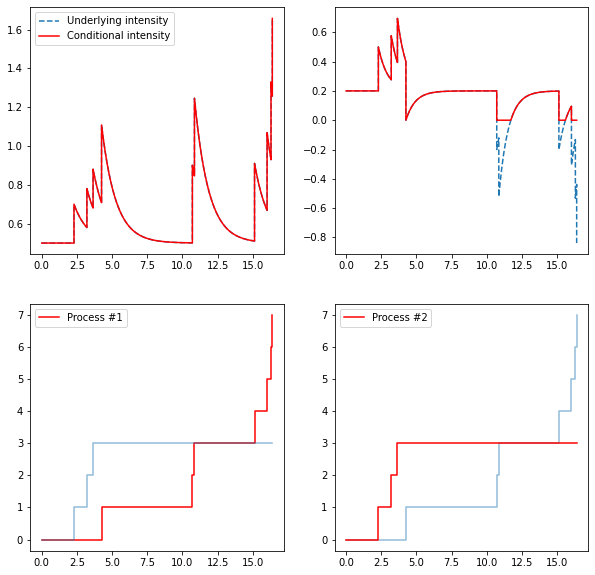

In [6]:
hawkes_multi = multivariate_exponential_hawkes_marked(m=m,
                                                      a=a, 
                                                      b=b, 
                                                      phi = phi, 
                                                      F= F, 
                                                      arg_phi={'gamma':phi_arg}, 
                                                      arg_F={'psi': 2}, 
                                                      max_jumps  = 10)

hawkes_multi.simulate()

fig,ax = plt.subplots(2,2, figsize = (10,10))
hawkes_multi.plot_intensity(ax = ax)

# Apply testing procedure

We present here the code use to apply different test procedure on Hawkes process. To that end, we start by simulating a synthetic dataset containing 500 repetitions of a Hawkes process.

In [7]:
## parameters
m=1
a = -0.6
b = 1



## simulation 

tList = []
for k in range(200):
    hawkes_ex =   exp_thinning_hawkes(m=m, a = a, b=b, max_jumps=500)
    hawkes_ex.simulate()    
    tList += [hawkes_ex.timestamps]   

In [8]:
print(f'Correspond to Tmax = {np.mean([x[-1] for x in tList ])}')

Correspond to Tmax = 794.850374137814


In [9]:
## fitting
learner = estimator_unidim_multi_rep()
learner.fit(tList, max_jump = True)

array([ 1.02585885, -0.62062917,  1.00017818])

Here, we simulated an unmarked Hawkes process and performed a Goodness-of-Fit (GOF) test, which tests the null hypothesis "the data is generated from a Hawkes process."

The first test checks whether the aggregated points of the process are uniformly distributed over the interval, and the second test checks whether the increments of the aggregated process follow an exponential distribution.

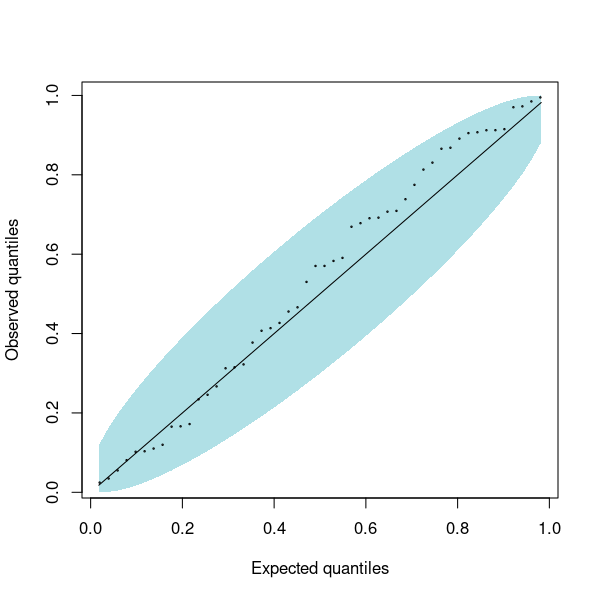

In [10]:
## Simulation done with a unmarked Hawkes Process  and test performed for a unmarked Hawkes Process 
## test is performed with uniform distribution

stats_unif = learner.GOF_bootstrap(compensator_func=unidim_EHP_compensator, test_type = 'uniform')

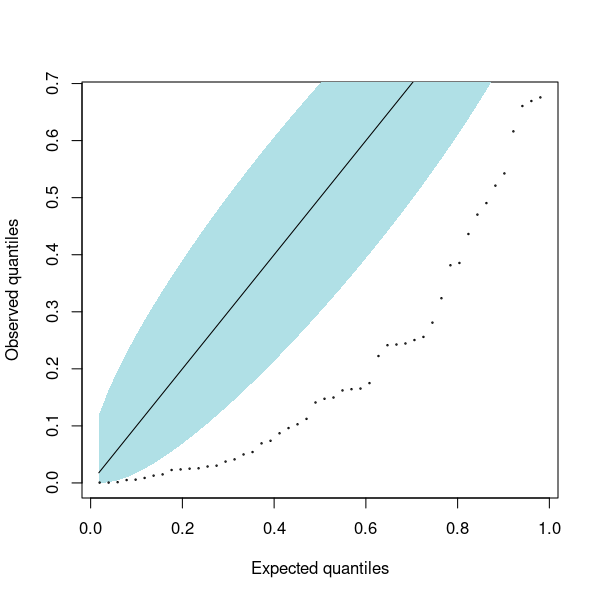

In [11]:
## Simulation done with a unmarked Hawkes Process  and test performed for a unmarked Hawkes Process 
## test is performed with exponential distribution


stats_unif = learner.GOF_bootstrap(compensator_func=unidim_EHP_compensator, test_type = 'expon')

## Test on one coefficient

Hypothesis under test: $\mathcal{H}_0 : m = 1 \quad \text{ vs } \quad \mathcal{H}_1 : m \ne 1$.

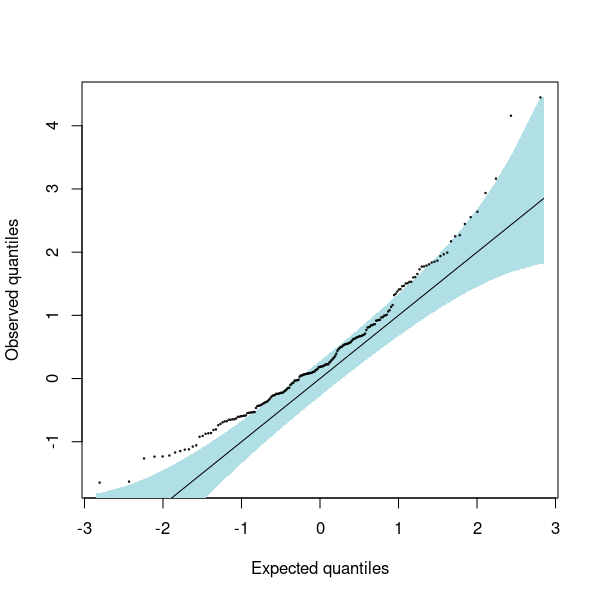

In [12]:
stat = learner.test_one_coeff(0,1, plot=True)  

Hypothesis under test: $\mathcal{H}_0 : a = -1 \quad \text{ vs } \quad \mathcal{H}_1 : a \ne -1$.

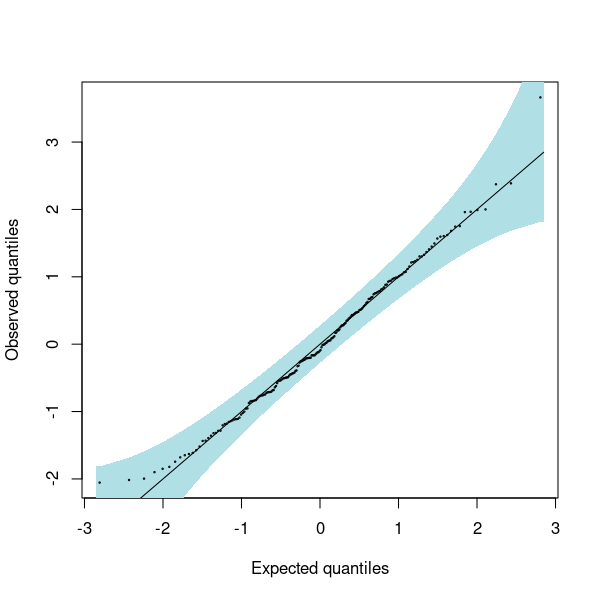

In [13]:
stat = learner.test_one_coeff(-1,1, plot = True)  

### Test of equality between coefficients 

Hypothesis under test: $\mathcal{H}_0 : a = m \quad \text{ vs } \quad \mathcal{H}_1 : a \ne m$.

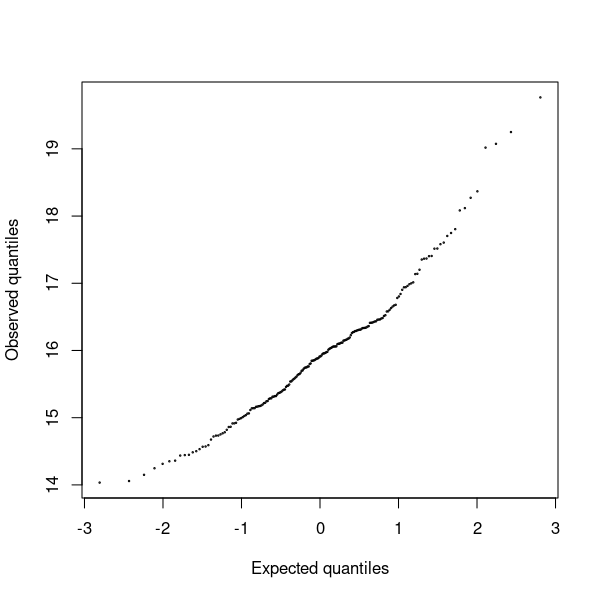

In [14]:
stat = learner.test_equality_coeff(0,1)

### Test on the model used for estimation

We present here different test on the model associated to the data, model relying on the GOF procedure. 

#### Test of the self-exiting assumption

Hypothesis under test: $\mathcal{H}_0 : \text{data are i.i.d represetation of a poisson model with an unknown parameter} $.

In [15]:
learner_poisson = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_poisson.fit(tList,max_jump = True)

array([0.62951436, 0.        , 1.        ])

Here, we simulated an unmarked Hawkes process with inhibition and performed a Goodness-of-Fit (GOF) test, which tests the null hypothesis "the data is generated from a Poisson process."
Once again the first test checks whether the aggregated points of the process are uniformly distributed over the interval, and the second test checks whether the increments of the aggregated process follow an exponential distribution.

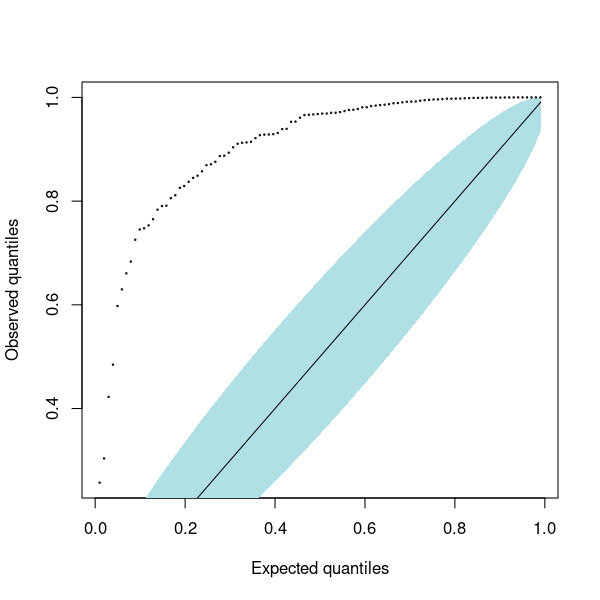

In [16]:
## Simulation done with Hawkes Process with inhibition and test performed for a Poisson
## test is performed with uniform distribution

stats_poisson = learner_poisson.GOF_bootstrap(compensator_func=poisson_compensator,
                                              test_type = 'uniform', 
                                              Nb_SubSample=100, 
                                              plot = True)

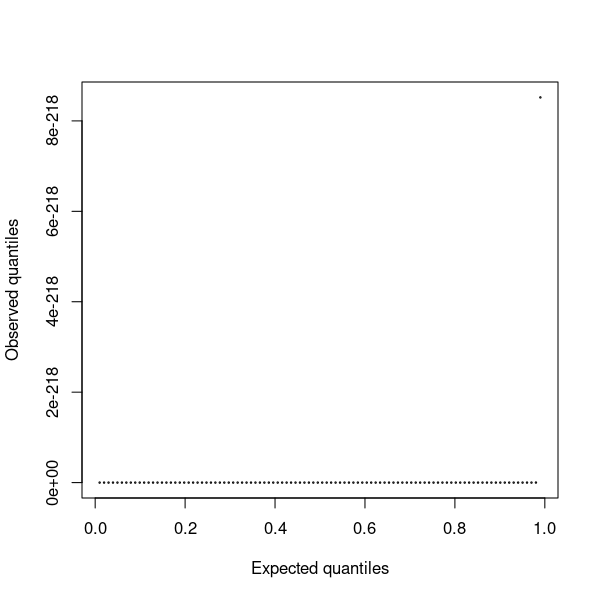

In [17]:
## Simulation done with Hawkes Process with inhibition and test performed for a Poisson
## test is performed with expnential distribution


stats_poisson = learner_poisson.GOF_bootstrap(compensator_func=poisson_compensator,
                                              test_type = 'expon', 
                                              Nb_SubSample=100, 
                                              plot = True)

### Test of the inhibition assumption

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a hawkes model inhibition} $$

In [18]:
learner_hawkes_ex = estimator_unidim_multi_rep(a_bound=0)
learner_hawkes_ex.fit(tList, max_jump = True)

array([0.62951437, 0.        , 1.        ])

We simulated an unmarked Hawkes process with inhibition and performed a Goodness-of-Fit (GOF) test, which tests the null hypothesis "the data is generated from excitatory Hawkes process."


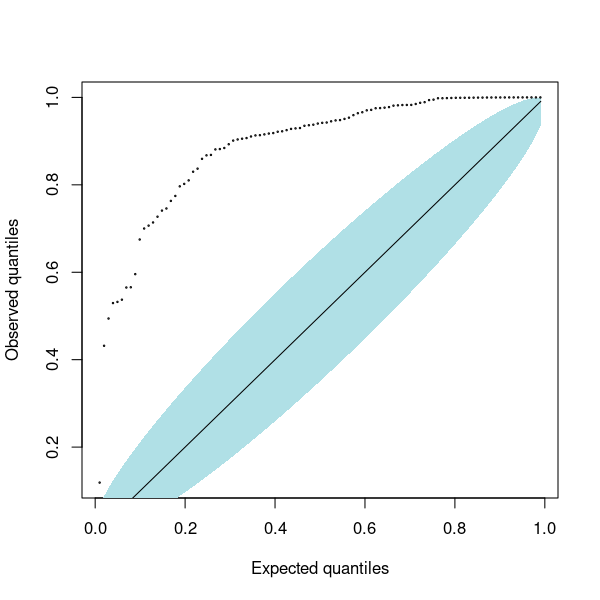

In [19]:
## Simulation done with Hawkes Process with inhibition and test performed for a Hawkes Process with only excitation allowed
## test is performed with uniform distribution


stats_hawkes_ex = learner_hawkes_ex.GOF_bootstrap(compensator_func=poisson_compensator,
                                              test_type = 'uniform', 
                                              Nb_SubSample=100, 
                                              plot = True)

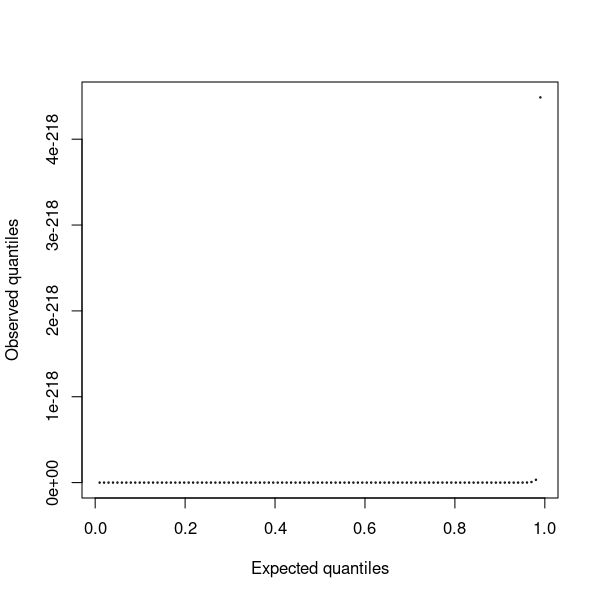

In [20]:
## Simulation done with Hawkes Process with inhibition and test performed for a Hawkes Process with only excitation allowed
## test is performed with exponential distribution

stats_hawkes_ex = learner_hawkes_ex.GOF_bootstrap(compensator_func=poisson_compensator,
                                              test_type = 'expon', 
                                              Nb_SubSample=100, 
                                              plot = True)

### Test of the marked assumpation

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a marked hawkes model} $$

In [30]:
m,a,b = 1, 1, 0.7

from function_test import *


tlist, mlist = [], []

for k in range(200):
    hawkes = exp_thinning_hawkes_marked(m=m,
                                            a=a, 
                                            b=b, 
                                            F=F, 
                                            arg_F={'psi':1.5}, 
                                            phi=phi, 
                                            arg_phi={'gamma':0.3}, 
                                            max_jumps=500)
    hawkes.simulate()
    tlist +=[[(time, mark) for time, mark in zip(hawkes.timestamps, hawkes.mark_list)]]

In [31]:
from function_test import *

learner = estimator_unidim_multi_rep(mark = True, 
                                        f = f, 
                                        phi = phi, 
                                        name_arg_f=['psi'], 
                                        name_arg_phi=['gamma'], 
                                        initial_guess_phi=[0], 
                                        initial_guess_f=[1], 
                                        bound_f=[(1e-5, None)], 
                                        bound_phi=[(None, None)])

learner.fit(tlist, max_jump=True)

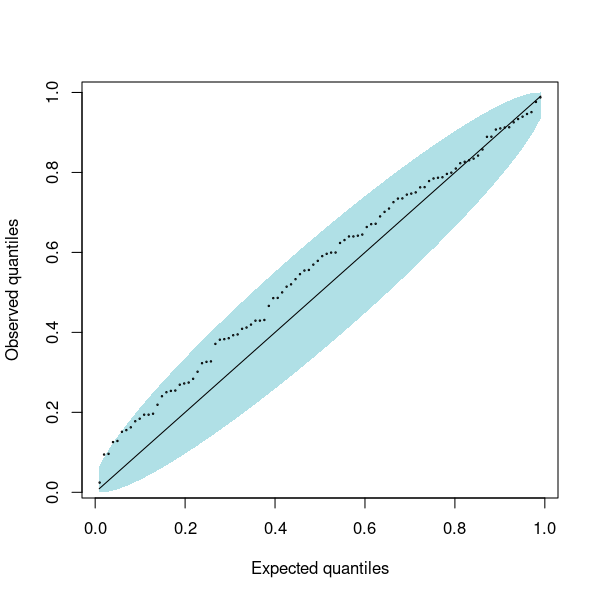

In [29]:
## Simulation done with a Marked Hawkes Process with inhibition and test performed for a Marked Hawkes Process 
## test is done with exponential distribution

pvals =learner.GOF_bootstrap(compensator_func=unidim_MEHP_compensator,
                             test_type = 'uniform', 
                                Nb_SubSample=100, 
                                plot = True)

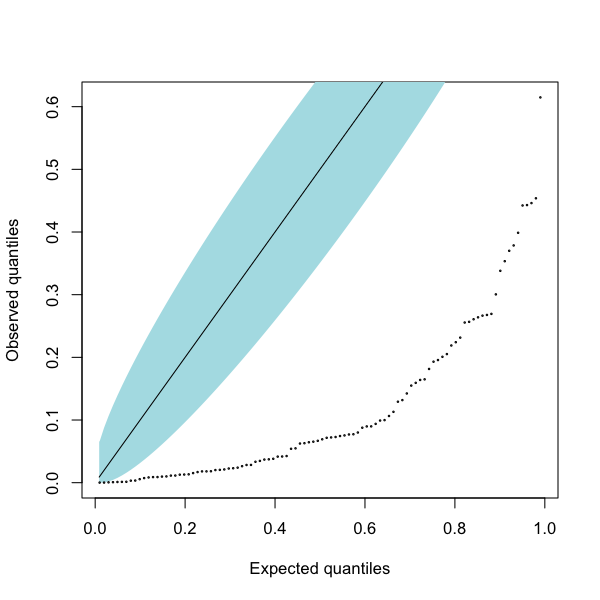

In [4]:
## Simulation done with a Marked Hawkes Process with inhibition and test performed for a unmarked Hawkes Process 
## test is done with exponential distribution

pvals =learner.GOF_bootstrap(compensator_func=unidim_MEHP_compensator,
                             test_type = 'expon', 
                                Nb_SubSample=100, 
                                plot = True)

# Real dataset

In [8]:
import datetime
import pandas as pd
import matplotlib.pyplot
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('earthquake.txt')

In [7]:

scaling =60*60*24

def split_date(x):
    y = x.split('+')[0]
    if len(y)<=19:
        y = y +'.0'
    z = datetime.datetime(year=int(y[:4]), month = int(y[5:7]), day=int(y[8:10]), hour = int(y[11:13]), minute=int(y[14:16]), second= int(y[17:19]), microsecond=int(y[20:]))  
    baseline =datetime.datetime(year = int(y[:4]), month=1, day=1, hour=0, minute=0, second=0)

    return((z-baseline).total_seconds()/scaling)


In [27]:
df['date1']= df['date'].apply(split_date)
#df['magnitudo'] = df['magnitudo'].apply( lambda x : x/12)
df['year']= df['date'].apply(lambda x : int(x[:4]))


tlist_marked = []
tlist = []

for year in np.unique(df['year']):
    
    diff_year = datetime.datetime(year = year+1, month=1, day=1, hour=0, minute=0, second=0)- datetime.datetime(year = year, month=1, day=1, hour=0, minute=0, second=0)
    tlist_marked +=  [[(0,0)] + list(df.loc[df.year == year, ['date1', 'magnitudo']].itertuples(index = False, name=None)) + [(diff_year.total_seconds()/scaling,0)] ]
    tlist += [[time for time,mark in tlist_marked[-1]]]

[7.85926067e-01 5.30739550e+00 4.27009712e-01 1.27528378e+04
 7.43880309e+00]


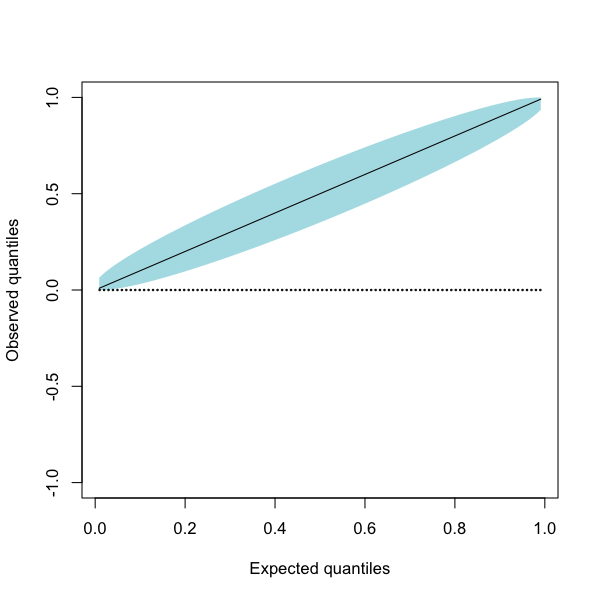

In [28]:
from function_test import f, phi1

learner_marked_hawkes = estimator_unidim_multi_rep(mark = True, 
                                                     f = f, 
                                                     phi = phi1, 
                                                     name_arg_f=['psi'], 
                                                     name_arg_phi=['gamma'], 
                                                     initial_guess_phi=[0], 
                                                     initial_guess_f=[1],
                                                     bound_f=[(0.01,None)], 
                                                     bound_phi=[(0,None)])
learner_marked_hawkes.fit(tlist_marked)
print(learner_marked_hawkes.mean_MLE)
pvals= learner_marked_hawkes.GOF_bootstrap(compensator_func=unidim_MEHP_compensator, Nb_SubSample=100 )


[0.34136511 1.42046942 8.54087617]


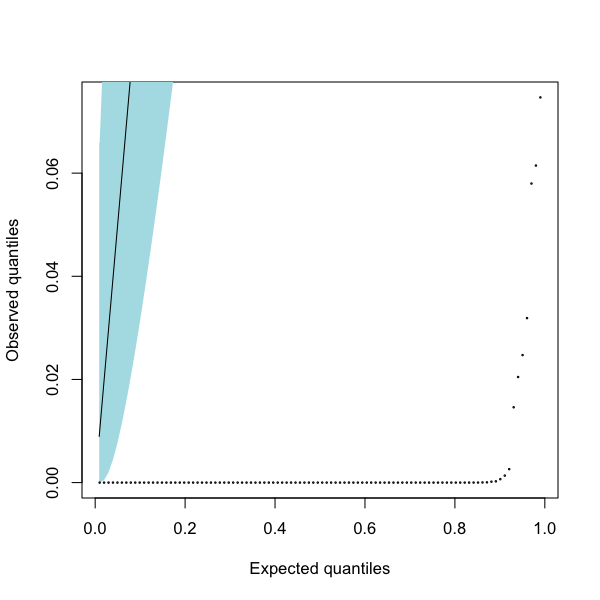

In [29]:
learner_hawkes = estimator_unidim_multi_rep()
learner_hawkes.fit(tlist)
print(learner_hawkes.mean_MLE)
pvals =learner_hawkes.GOF_bootstrap(compensator_func=unidim_EHP_compensator,Nb_SubSample=100)

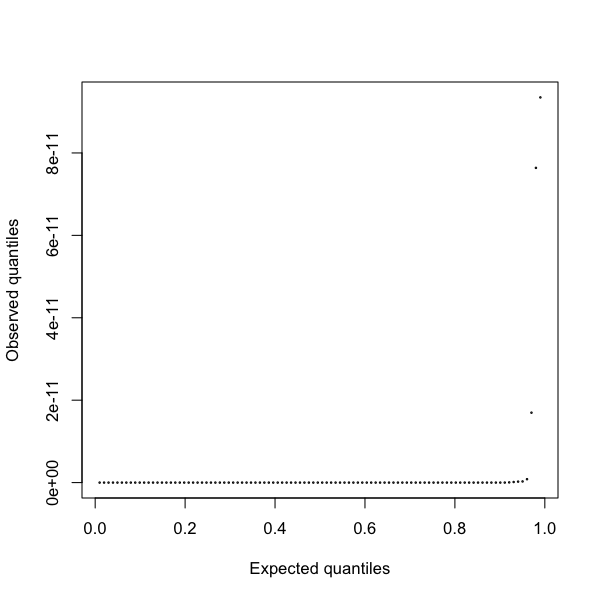

In [30]:
learner_marked_hawkes = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_marked_hawkes.fit(tlist)
pvals =learner_marked_hawkes.GOF_bootstrap(compensator_func=poisson_compensator,Nb_SubSample=100)